# Dense Neural Network Model

### Step 1: Import library

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping


from utils import evaluate_model_performance, time_sequence_generator, plot_mae_mse,create_results_dataframe, plot_actual_vs_predicted, load_and_preprocess_data
import importlib

import utils
importlib.reload(utils) 

<module 'utils' from '/Users/mac/Desktop/kingston/Deep-learning-assignment/utils.py'>

### Step 2: Import training data

In [3]:
data = load_and_preprocess_data()

(1200,)
(1171,) (1171,)


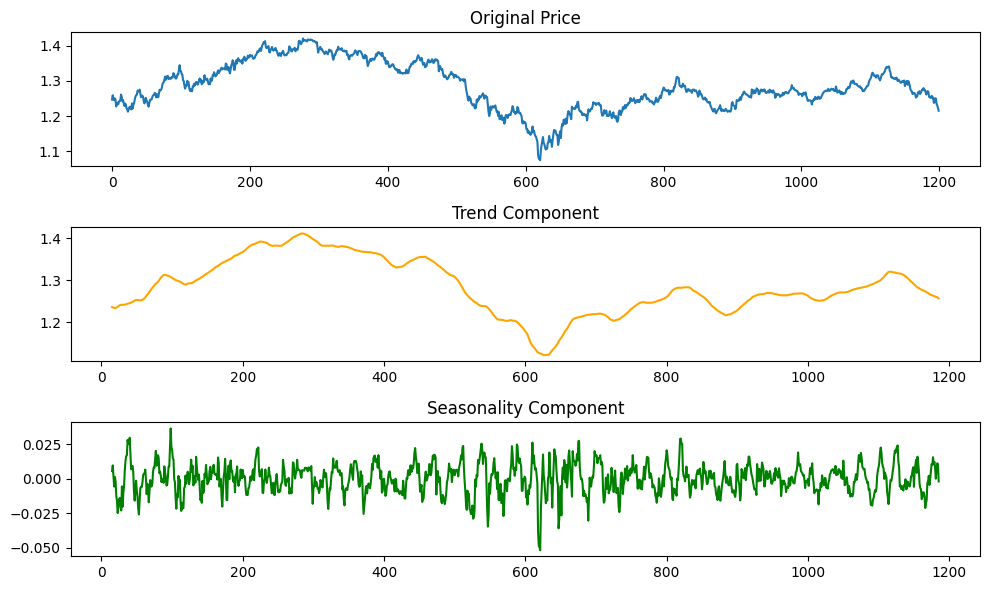

In [4]:
from keras.models import Sequential
# Example: Open prices for each day (replace with actual data)
prices = data['Open']

print(prices.shape)
# 1. Trend Component: Using a simple moving average (or you can use other techniques like polynomial fitting)
window_size = 30  # Window size for trend smoothing (e.g., 30 days)
trend = prices.rolling(window=window_size, center=True).mean()
trend = trend.dropna()

# Update y to align with the dropped NaN values
y = prices.loc[trend.index]
print(trend.shape, y.shape)

# 2. Seasonal Component: Difference the price with the trend to get seasonal patterns
seasonality = prices - trend

# 3. Residual (remaining) Component: Subtract trend and seasonality from the original price
residual = prices - (trend + seasonality)

# Plotting (Optional)
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(prices, label='Original Price')
plt.title("Original Price")

plt.subplot(3, 1, 2)
plt.plot(trend, label='Trend', color='orange')
plt.title("Trend Component")

plt.subplot(3, 1, 3)
plt.plot(seasonality, label='Seasonality', color='green')
plt.title("Seasonality Component")

plt.tight_layout()
plt.show()

# Make sure the data is aligned properly after dropping NaNs caused by rolling window
seasonality = seasonality.dropna()
trend = trend.dropna()
residual = residual.dropna()


Trial 10 Complete [00h 00m 04s]
val_loss: 0.045032795518636703

Best val_loss So Far: 5.636324749502819e-05
Total elapsed time: 00h 00m 50s
Epoch 1/200


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0222 - mae: 0.1185 - mse: 0.0222 - val_loss: 0.0021 - val_mae: 0.0446 - val_mse: 0.0021
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - mae: 0.0976 - mse: 0.0161 - val_loss: 6.3830e-04 - val_mae: 0.0222 - val_mse: 6.3830e-04
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - mae: 0.0968 - mse: 0.0144 - val_loss: 0.0021 - val_mae: 0.0430 - val_mse: 0.0021
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125 - mae: 0.0881 - mse: 0.0125 - val_loss: 1.8117e-04 - val_mae: 0.0111 - val_mse: 1.8117e-04
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - mae: 0.0839 - mse: 0.0110 - val_loss: 7.7320e-04 - val_mae: 0.0259 - val_mse: 7.7320e-04
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - mae: 0.0843 - mse: 0.0111 - val_loss: 0.0018 - val_mae: 0.0408 - val_mse: 0.0018
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - mae: 0.0881 - mse: 0.0119 

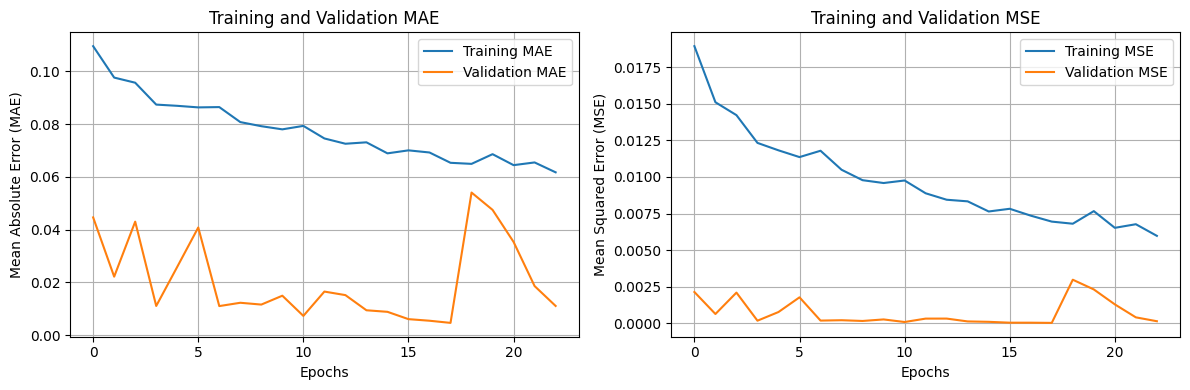

MAE: 0.0111
MSE: 0.0001
MAPE: 2.21%
R²: 0.7078


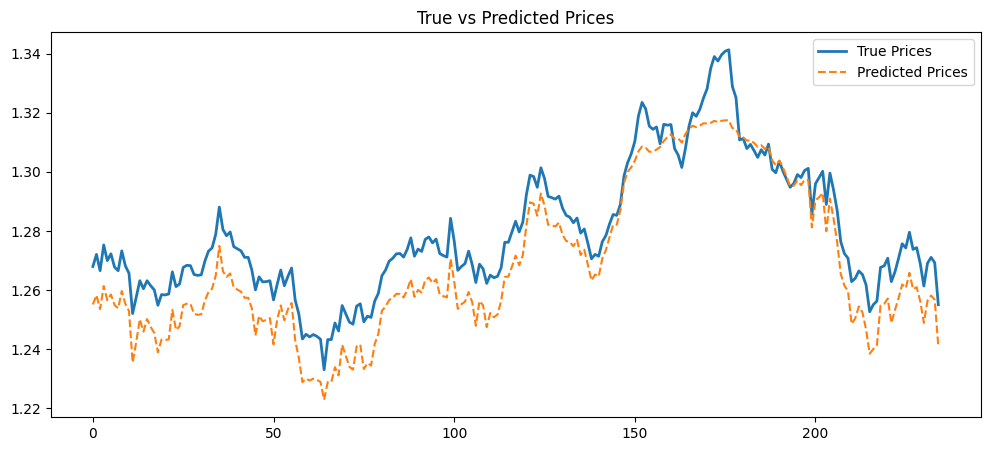

In [5]:
from keras.models import Sequential
from keras.optimizers import Adam
# --- 1. Split Data First (Avoid Data Leakage) ---
X = pd.concat([trend, seasonality, residual], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- 2. Scale Data After Splitting ---
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)  # Use transform, not fit_transform!

# --- 3. Hyperparameter Tuning ---
def build_model(hp):
    model = Sequential()
    # Input layer
    model.add(Dense(
        units=hp.Int('units_1', 32, 128, step=32),
        activation='relu',
        input_dim=X_train_scaled.shape[1]
    ))
    # Hidden layers
    for i in range(hp.Int('num_layers', 3, 5)):
        model.add(Dense(
            units=hp.Int(f'units_{i+2}', 64, 256, step=32),
            activation='relu'
        ))
        model.add(Dropout(
            rate=hp.Float(f'dropout_{i+2}', 0.1, 0.5, step=0.1)
        ))
    # Output layer
    model.add(Dense(1))
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', 1e-5, 1e-2, sampling='log')),
        loss='mse',
        metrics=['mae', 'mse']
    )
    return model

# Import RandomSearch from keras-tuner
from keras_tuner import RandomSearch

# Initialize tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='kt_dir',
    project_name='price_prediction'
)

# Early stopping to save time
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Search
tuner.search(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop]
)

# --- 4. Train Best Model ---
best_model = tuner.get_best_models(num_models=1)[0]

# Callbacks

history = best_model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop],
    verbose=1
)

# --- 5. Evaluate ---
y_pred = best_model.predict(X_test_scaled)
# y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_test_orig = y_test.values

# Metrics
mae = mean_absolute_error(y_test_orig, y_pred)
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
mape = np.mean(np.abs((y_test_orig - y_pred) / y_test_orig)) * 100

plot_mae_mse(history)
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


# --- 6. Plot Results ---
plt.figure(figsize=(12, 5))
plt.plot(y_test_orig, label='True Prices', linewidth=2)
plt.plot(y_pred, label='Predicted Prices', linestyle='--')
plt.title("True vs Predicted Prices")
plt.legend()
plt.show()

### Step 3: Separate the data to Train, Validation & Test 


In [6]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test.values - y_pred.flatten()) / y_test.values)) * 100

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.011099046938470065
Mean Squared Error (MSE): 0.0001444212662338895
Mean Absolute Percentage Error (MAPE): 0.8705904620619012%
R-squared (R²): 0.7078358517703198


In [7]:
from utils import split_train_validate_test

train_data, validation_data, test_data = split_train_validate_test(data, 0.7, 0.15, 0.15)


### Step 4: Data Feature extraction

In [8]:
from pandas import DataFrame

## Extract feature from the data
def extract_feature(d: pd.DataFrame):
    D = pd.DataFrame()
    
    # Convert timestamp to datetime
    dt = pd.to_datetime(d['Time'], unit='s')

    # Basic time features
    D['Day'] = dt.dt.day
    D['Month'] = dt.dt.month
    D['Year'] = dt.dt.year
    D['DayOfWeek'] = dt.dt.dayofweek  # Monday=0, Sunday=6
    D['DayOfYear'] = dt.dt.dayofyear
    D['WeekOfYear'] = dt.dt.isocalendar().week

    # Cyclic Encoding
    D["sin_day"] = np.sin(2 * np.pi * D["DayOfYear"] / 365)
    D["cos_day"] = np.cos(2 * np.pi * D["DayOfYear"] / 365)

    D["sin_week"] = np.sin(2 * np.pi * D["DayOfWeek"] / 7)
    D["cos_week"] = np.cos(2 * np.pi * D["DayOfWeek"] / 7)

    D["sin_month"] = np.sin(2 * np.pi * D["Month"] / 12)
    D["cos_month"] = np.cos(2 * np.pi * D["Month"] / 12)

    return D

X_train = extract_feature(train_data)
y_train = train_data['Open']

X_val = extract_feature(validation_data)
y_val = validation_data['Open']

X_test = extract_feature(test_data)
y_test = test_data['Open']


X_whole = extract_feature(data)

### Step 5: Scaling the data

In [9]:
features = ['Day', 'Month', 'Year', 'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'sin_day', 'cos_day', 'sin_week', 'cos_week', 'sin_month', 'cos_month']

scaler = MinMaxScaler()
scaler.fit(X_train[features].values)

X_train_scaled = scaler.transform(X_train[features].values)
X_val_scaled = scaler.transform(X_val[features].values)
X_test_scaled = scaler.transform(X_test[features].values)

X_whole_scaled = scaler.transform(X_whole[features].values)

### Step 2: Hyper-tuning the model 

In [10]:

# Hyperparameter tuning setup for Dense Neural Network
def build_dnn_model(hp):
    model = keras.Sequential()
    
    # Input layer
    model.add(keras.layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))
    
    # Tune number of dense layers (2-4 layers)
    for i in range(hp.Int('num_layers', 5, 7, 1)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=128, max_value=164, step=12),
            activation='relu')
        )
        model.add(BatchNormalization())
        model.add(Dropout(
            hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)
        ))
    
    # Output layer
    model.add(Dense(1))  # Regression output
    
    # Tune learning rate
    lr = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='mae',
        metrics=['mae', 'mse']
    )
    return model

# Initialize tuner
tuner = kt.Hyperband(
    build_dnn_model,
    objective='val_mae',
    max_epochs=50,
    factor=3,
    directory='tuning',
    project_name='gbpusd_dnn_prediction',
    overwrite=True  # Prevents reloading issues
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_mae',
    patience=15,
    restore_best_weights=True
)

# Perform hyperparameter search
print("Starting DNN hyperparameter search...")
tuner.search(
    X_train_scaled, y_train,
    epochs=200,
    validation_data=(X_val_scaled, y_test),
    callbacks=[early_stopping],
    batch_size=32,  # Tune batch size
    verbose=2
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the final model
dnn_model = tuner.hypermodel.build(best_hps)

history = dnn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Trial 90 Complete [00h 00m 08s]
val_mae: 0.031236648559570312

Best val_mae So Far: 0.02102961763739586
Total elapsed time: 00h 06m 22s
Epoch 1/200


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2938 - mae: 1.2938 - mse: 2.7644 - val_loss: 0.0714 - val_mae: 0.0714 - val_mse: 0.0076
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5546 - mae: 0.5546 - mse: 0.5734 - val_loss: 0.0557 - val_mae: 0.0557 - val_mse: 0.0046
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3026 - mae: 0.3026 - mse: 0.1600 - val_loss: 0.0754 - val_mae: 0.0754 - val_mse: 0.0083
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2681 - mae: 0.2681 - mse: 0.1303 - val_loss: 0.1297 - val_mae: 0.1297 - val_mse: 0.0232
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2074 - mae: 0.2074 - mse: 0.0758 - val_loss: 0.0429 - val_mae: 0.0429 - val_mse: 0.0025
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1564 - mae: 0.1564 - mse: 0.0442 - val_loss: 0.1054 - val_mae: 0.1054 - val_mse: 0.0144
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1304 - mae: 0.1304 - mse: 0.0312 - val_loss: 0.1357 - val

### Step 6: Best Parameters

In [11]:
print("-----------Best Parameter------")
best_hps_table = pd.DataFrame(list(best_hps.values.items()), columns=["Hyperparameter", "Value"])
print(best_hps_table)

-----------Best Parameter------
         Hyperparameter     Value
0            num_layers         6
1               units_0       164
2             dropout_0       0.2
3               units_1       140
4             dropout_1       0.1
5               units_2       152
6             dropout_2       0.2
7               units_3       128
8             dropout_3       0.3
9               units_4       128
10            dropout_4       0.5
11                   lr  0.005992
12              units_5       164
13            dropout_5       0.1
14              units_6       128
15            dropout_6       0.2
16         tuner/epochs        17
17  tuner/initial_epoch         6
18        tuner/bracket         2
19          tuner/round         1
20       tuner/trial_id      0066


### Step 6: Evaluation

In [12]:
## Predict the values on the test data 
y_pred = dnn_model.predict(X_test_scaled)
evaluate_model_performance(y_test.values, y_pred)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Model Performance on Test Data:
------------------------
R^2 Score: -9.7602
Mean Absolute Error (MAE): 0.0656
Mean Squared Error (MSE): 0.0065
Mean Absolute Percentage Error (MAPE): 4.85%


### Step 7: Plotting MAE & MSE

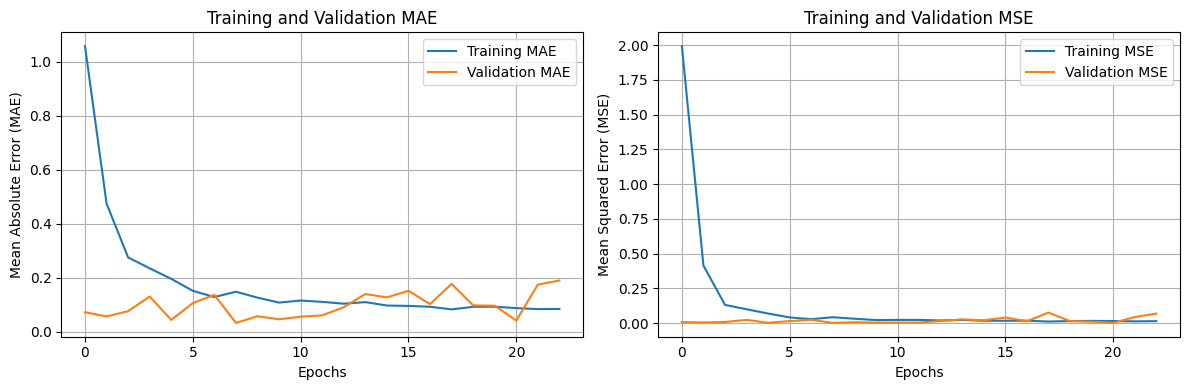

In [13]:
plot_mae_mse(history)

### Step 8: Plot the data predicted & actual

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step


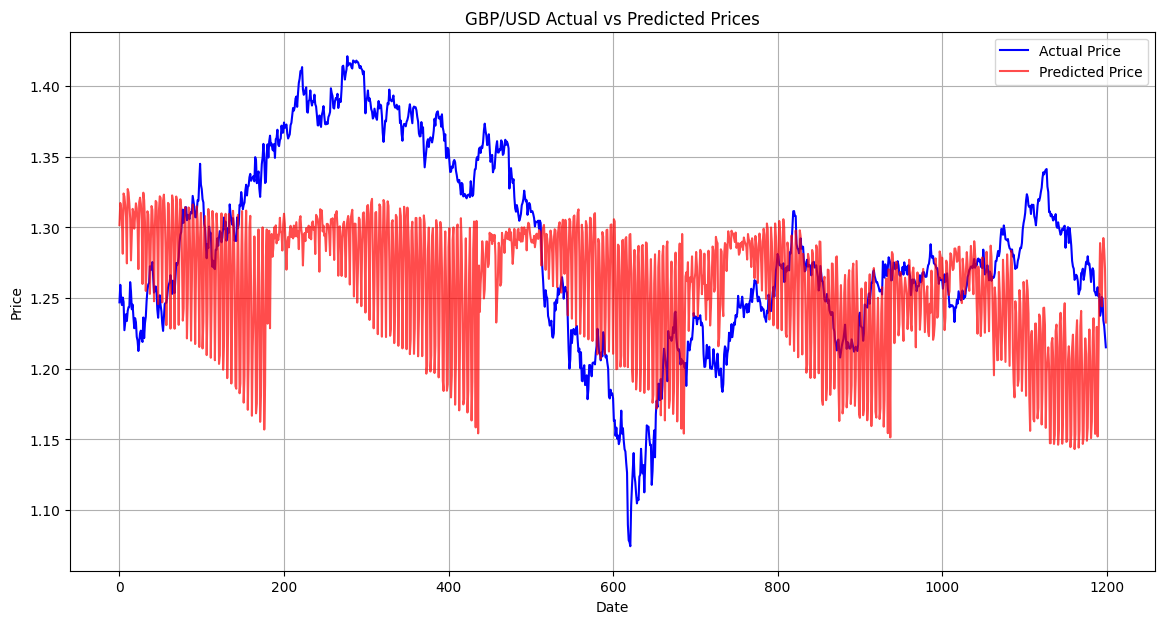

In [14]:
 
def create_results_dataframe(dnn_model, X_scaled, data: DataFrame):
    """
    Create a DataFrame with actual and predicted prices.
    """
    predictions = dnn_model.predict(X_scaled).flatten()
    results = pd.DataFrame({
        'Date': data.index,
        'Actual_Price': data['Open'].values,
        'Predicted_Price': predictions
    })
    return results

def plot_actual_vs_predicted(results):
    """
    Plot actual vs predicted prices.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(results['Date'], results['Actual_Price'], label='Actual Price', color='blue')
    plt.plot(results['Date'], results['Predicted_Price'], label='Predicted Price', color='red', alpha=0.7)
    plt.title('GBP/USD Actual vs Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
# Generate results DataFrame
results = create_results_dataframe(dnn_model, X_whole_scaled, data)
# Plot actual vs predicted prices
plot_actual_vs_predicted(results)

In [15]:
dnn_model.save('gbpusd_price_predictor.h5')